# Frank-Wolfe variants for effective attacks on Inception V3 model

### Andrea Sipka, MSc Data Science, University of Padova

## Background information

**Adversarial image** is an image that tricks an image classifier, but not a human. If you, the human, see an adversarial image of a kitten, it will be obvious to you that the picture contains a kitten, but state-of-the-art image classifier with high accuracy rate, that this image was designed to fool, will misclassify it.

Many different adversarial attacks have been designed in the recent years, due to interest in computer vision, but also image recognition's increasing popularity in the application field - for example, in policing and security.

Adversarial attacks can be **white-box** or **black-box**. In white box attacks, the adversary has access to the target model, and in the black-box setting, the adversary has access to the input and the output of the model, but not model settings. It's important to point out that the "output" of the model, in the classification task, is a vector of probabilities of an image belonging to each class, rather than just a prediction class.

Adversarial attacks can also be **untargeted** or **targeted**. In an untargeted attack, we simply aim to misclassify the image into any other class, while in the targeted attack, we aim to misclassify an image into a particular class. For example, we might decide that an input image of a "kitten" should be misclassified as a "kitchen sink". As targeted attacks are harder, they are the ones covered in this notebook.

To formulate adversarial attack as an optimization problem, we let $\ell (\boldsymbol{x}, y)$ be the classification loss function of the deep neural network we are targeting with the attack, where $\boldsymbol{x} \in \Re^d$ is input and $y$ is a corresponding label.

In implementation below, the loss function used is categorical cross entropy, a popular loss function for training neural network to tackle multi-class classification problems. If we let $y_{tar}$ denote the target class of our attack, the function we are trying to minimize is:
$$ f (\boldsymbol{x}) = \ell (\boldsymbol{x}, y_{tar}) $$
subject to the following constraint, where $\boldsymbol{x}_{ori}$ denotes the original input:
$$ || \boldsymbol{x} - \boldsymbol{x}_{ori} ||_p \leq \epsilon $$
The normalization this implementation focuses on is $p = \infty$

## What is this notebook?

This notebook implements a few Frank-Wolfe variants which can be used for adversarial attacks on images.
Description of algorithms and theoretical background can be found in the paper "A Frank-Wolfe framework for efficient and effective adversarial attacks" [here](https://openreview.net/pdf?id=Hyewf3AqYX).

In addition to the white and black box implementations from the paper above, I present a modified Frank-Wolfe algorithm with momentum, from [this](https://arxiv.org/pdf/1811.10828.pdf) paper.

The main difference between two papers and the original Frank Wolfe method is as follows:
* Paper 1 (algorithms White box and Black box) calls the linear minimization oracle (which result is denoted by $v_t$ in algorith description) over a more relaxed constraint set $\chi_\lambda = \{ \boldsymbol{x} | \; || \boldsymbol{x} - \boldsymbol{x}_{ori}||_p \leq \lambda \epsilon \}$ for $\lambda \geq 1 $
* Paper 2 implements the momentum term which nudges the gradient in the direction of the previous step

In addition to algorithm implementation, some experimental results are presented.

Model being attacked is Inception V3 model (1st runner up for image classification in the The ImageNet Large Scale Visual Recognition Challenge 2015). Inception V3 is a complex convolutional neural network developed by researchers at Google and presented in the paper [here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf). The Inception V3 model used here is pre-trained on an Imagenet training dataset for 1000 classes.

Dataset used for validation is Imagenet Validation dataset, which includes 50,000 images across 1000 classes. Github repository includes a sample of these (one image per class) and instructions on how to obtain full dataset can be found below.

The notebook is intended to be an educational tool. As such, explainability is favoured over performance (hence the use of the notebook). While effort was made to use efficient Python, the efficiency of code can be improved vastly by the use of sessions, GPU processing, and running through Terminal.

Code is heavily commented (as it should always be!) and every function in this notebook is docstringed. 
This means that if you want to know what a function (e.g. run_whitebox_attack()) does, you do this:

In [379]:
print(run_whitebox_attack.__doc__)


    Function performs a targeted white box adversarial attack 
    on an imput image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    


In [1]:
import keras
from keras import backend as K
from keras import losses
from keras.applications import inception_v3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os.path
import os

%matplotlib inline

Using TensorFlow backend.


## Where did the data come from?

Imagenet validation set can be downloaded from Academic torents. However, it doesn't come with labels. The code box below should be ran only once, if you don't have labeled data, as it adds labels to the image names. All of this is mildly infuriating because the way labels are numbered in Keras isn't the same as the way labels are numbered in the actual Imagenet validation.

The following code blob assigns Keras compatible labels to all the files.

val.txt comes from [here](http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz)

Imagenet validation set torrent can be taken from [here](https://academictorrents.com/details/5d6d0df7ed81efd49ca99ea4737e0ae5e3a5f2e5)

Once downloaded, data was unzipped into the folder called "imagenetdata".

**Example**
* Orginal file name: "ILSVRC2012_val_00035997.JPEG"
* Original file label: 172
* New file name: "172_ILSVRC2012_val_00035997.JPEG"

In [ ]:
# Get current directory
currentdir = os.getcwd()

# Read in label file
f = open("val.txt","r")
y_val = f.read().strip().split("\n")
y_values = [int(x.split(' ')[1]) for x in y_val]

# Get file names from the folder
file_list = sorted(os.listdir("imagenetdata/"))

# Change the directory
os.chdir("imagenetdata/")

for i, filename in enumerate(file_list):
    # Create new filename by adding label_ to each name
    dst = str(y_values[i])+'_'+filename
    # Actual renaming
    os.rename(filename, dst)
    
# Go back to the original directory
os.chdir(currentdir)

## Load inception model

This will load pre-trained inception model with imagenet weights. If model does not exist, it will be downloaded.

In [2]:
# Load the Inception_V3 model with imagenet weights
inception_model = inception_v3.InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


## Function to use

In [3]:
def preprocess_img(filename):
    """
    Function takes in original image from file passed in,
    and coverts it into a format appropriate to be used with imagenet models
       
    Parameters:
    filename (str): Name of the image file from the imagenetdata folder

    Returns:
    nparray of shape (1, 299, 299, 3) which can be used on inception_v3 model
    """
    
    # load an image in PIL format
    original_image = load_img('imagenetdata/'+filename, target_size=(299, 299))
    
    # convert the PIL image (width, height) to a NumPy array (height, width, channel)
    numpy_image = img_to_array(original_image)
    
    # Convert the image into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
    input_image = np.expand_dims(numpy_image, axis=0)
    
    # Preprocessing required for inception V3
    processed_image_inception_v3 = inception_v3.preprocess_input(input_image.copy())
    
    return processed_image_inception_v3

In [4]:
def generate_target(truelabel):
    """
    Function generates a target label for the attacks.
       
    Parameters:
    truelabel (int): Actual label based on ground truth

    Returns:
    1. nparray of shape 1, 1000 with all 0s and a single 1 for the target label
    2. intiger denoting target class
    """
    
    # Pick a random label other than the actual label
    target_class_index = random.choice(list(range(0, truelabel))+list(range(truelabel+1, 1000)))
    
    # Create an np array with all 0s but the 1 for the label
    target_class = np.zeros((1, 1000))
    target_class[0,target_class_index] = 1.
    
    return target_class_index, target_class

In [5]:
def run_classification(input_img, target_label):
    """
    Function uses the pre-loaded inception model to classify the image passed in
       
    Parameters:
    input_img (np array): Input image to be classified
    target_label (int): Target label for the attack

    Returns:
    1. A boolean that is True if the predicted target is the target class
    2. Integer denoting which class has been predicted
    """    
    
    # Run the model to predict based on pre-processed image
    predictions_inception_v3 = inception_model.predict(input_img)
    
    # Get the predicted label by finding the maximum value
    predicted_label = np.argmax(predictions_inception_v3)
    
    # Evaluate if the target label has been reached by comparing        
    target_reached = (target_label == predicted_label)
    
    return target_reached, predicted_label

In [129]:
# Placeholder variable where fake class comes in
target_class = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss = losses.categorical_crossentropy(target_class, inception_model.output) 

# Input image
input_img = inception_model.input 

# Compute gradients with respect to loss
grads = K.gradients(adversarial_loss, input_img)[0]

# Output for the functon
outputs = [grads]

# Function to use during attack
fetch_grads = K.function([input_img, target_class], outputs)

def evaluate_grads(input_img, tgt_class):
    """
    Function uses the keras functions described above to return 
    gradients w.r.t the categorical loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Gradients of the image w.r.t. the loss
    """ 
    output = fetch_grads([input_img, tgt_class])
    
    return output[0]

In [82]:
# Placeholder variable where fake class comes in
target_class_black = K.zeros(shape=(1,1000))

# Calculate loss with categorical cross entropy
adversarial_loss_black = losses.categorical_crossentropy(target_class_black, inception_model.output) 

# Input image
input_img_black = inception_model.input 

# Output for the functon
outputs_black = [adversarial_loss_black]

# Function to use during attack
fetch_loss = K.function([input_img_black, target_class_black], outputs_black)

def evaluate_loss(input_img, tgt_class):
    """
    Function uses the keras functions described above to return loss
       
    Parameters:
    input_img (np array): Input image to be classified
    tgt_class (np array): np array for target label

    Returns:
    Categorical cross entropy loss
    """ 
    output = fetch_loss([input_img, tgt_class])
    
    return output[0]

In [7]:
def deprocess_image(x):
    """
    Function inverts the processing that was required for modeling.
    Used for display purposes.
    Shamefully lifted from the Keras examples directory.
       
    Parameters:
    x (np array): Input image to be deprocessed

    Returns:
    Deprocessed image
    """     
    
    x = np.copy(x)
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [300]:
def plot_sidebyside(img1, img2):
    """
    Function that plots two images side by side, and their predicted classes, alongiside probability confidence.
       
    Parameters:
    img1 (np array): Input image to be displayed on the left
    img2 (np array): Input image to be displayed on the right
    """ 
    f, axs= plt.subplots(1,2, figsize=(14,20))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img1), top=1)[0][0]
    axs[0].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[0].imshow(deprocess_image(img1))

    top_predicted_label = inception_v3.decode_predictions(inception_model.predict(img2), top=1)[0][0]
    axs[1].set_title('Predicted: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[1].imshow(deprocess_image(img2))

In [433]:
def plot_grid(maxid, images_df):
    """
    Function that plots four images side by side, and their predicted classes and probability confidence.
       
    Parameters:
    experiment (int): Experiment ID
    images_df (DataFrame): A dataframe with images resulting from the experiment
    """ 
    f, axs= plt.subplots(4,4, figsize=(14,16))
    
    for enum, i in enumerate(range(maxid-3,maxid+1)):
                
        top_predicted_label = inception_v3.decode_predictions(inception_model.predict(images_df.iloc[i].original_image), top=1)[0][0]
        axs[enum, 0].set_title('Original: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
        axs[enum, 0].imshow(deprocess_image(images_df.iloc[i].original_image))

        top_predicted_label = inception_v3.decode_predictions(inception_model.predict(images_df.iloc[i].whitebox_image), top=1)[0][0]
        axs[enum, 1].set_title('Target: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
        axs[enum, 1].imshow(deprocess_image(images_df.iloc[i].example_image))

        top_predicted_label = inception_v3.decode_predictions(inception_model.predict(images_df.iloc[i].whitebox_image), top=1)[0][0]
        axs[enum, 2].set_title('White box: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
        axs[enum, 2].imshow(deprocess_image(images_df.iloc[i].whitebox_image))

        top_predicted_label = inception_v3.decode_predictions(inception_model.predict(images_df.iloc[i].momentum_image), top=1)[0][0]
        axs[enum, 3].set_title('Momentum: %s \n(%f)' % (top_predicted_label[1], top_predicted_label[2]))
        axs[enum, 3].imshow(deprocess_image(images_df.iloc[i].momentum_image))
    
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        
    plt.show()

## Attack algorithms

### White box attack with an $L_\infty$ norm.

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, $\lambda > 0$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$
- **for** $t = 1 ... T$ **do**:
    - $v_t = \text{argmin}_{v \in \chi_\lambda } \langle v, \nabla f(x_t) \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
    - **if** $\lambda > 1$ **then**
        - $x_{t+1} = P_\chi (x_{t+1}) $
    - **end if**
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \lambda \cdot \epsilon \cdot \text{sign} (\nabla f(x_t)) + x_{\text{ori}}$

***

In [285]:
def run_whitebox_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an imput image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    5. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    epsilon_lambda = 0.05 
    gamma_t = 0.03 # stepsize
    
    #epsilon_lambda_todo = np.arange(0.005, 0.5, 0.005) # if looping for hyperparameter search
    #gammas = np.arange(0.001, 0.25, 0.001) # if looping for hyperparameter search    
    #for epsilon_lambda_t in epsilon_lambda_todo:
        #print('Running epsilon * lambda: ', epsilon_lambda_t)
        #epsilon_lambda = epsilon_lambda_t
    
    # ALGORITHM Step 2
    x = np.copy(x_ori)

    # ALGORITHM Step 3
    time_start = time.time()
    for iteration in range(10000):

        # Classifying with the model
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            # if attack successful, stop iterating
            break

        # Getting gradients
        grad_values = evaluate_grads(x, target_class)

        # ALGORITHM Step 4: Linear Minimisation Oracle
        v_t = - epsilon_lambda * np.sign(grad_values) + x_ori

        # ALGORITHM Step 5
        d_t = v_t - x

        # ALGORITHM Step 6
        x = x + gamma_t * d_t

        # ALGORITHM Step 7
        x = x_ori + np.clip((x - x_ori), -(epsilon_lambda), (epsilon_lambda))

    time_total = time.time() - time_start
    
    # calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful.')
        
    #result_array.append([epsilon_lambda, target_reached, time_total, distortion])

    return x_ori, x, time_total, distortion, target_reached

### Black box attack with an $L_\infty$ norm and sampling from $N \sim$

***
#### Black box attack algorithm
- **input:**: number of iterations T, step size $\gamma_t$, $\lambda > 0$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$
- **for** $t = 1 ... T$ **do**:
    - $q_t = \text{ZERO_ORD_GRAD_EST} (x_t)$
    - $v_t = \text{argmin}_{v \in \chi_\lambda } \langle v, \nabla q_t \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
    - **if** $\lambda > 1$ **then**
        - $x_{t+1} = P_\chi (x_{t+1}) $
    - **end if**
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \lambda \cdot \epsilon \cdot \text{sign} (q_t) + x_{\text{ori}}$
***
#### Zeroth order gradient estimation algorithm (ZERO_ORD_GRAD_EST)
- **input:**: number of gradient estimation samples b, sampling parameter $\delta_t$
- $q = 0$
- **for** $i = 1 ... b$ **do**:
    - sample $u_i$ uniformly from standard Gaussian distribution $N(0,I)$
    - $q = q + \dfrac{d}{2 \delta_t b} (f(x_t + \delta_t u_i) - f(x_t - \delta_t u_i))u_i$
- **end for**
- **output:** $q$

***


Assuming the following hyperparameters (values from the source paper)
* $\lambda = 30$
* $T = 10000$
* $\epsilon = 0.05$
* $b = 25$
* Step size $\dfrac{0.03}{\sqrt{t}}$, starting from $\gamma = 0.03$, where t is iteration in T
* $\delta_t = 0.01$

In [202]:
def run_blackbox_attack(img_in, tgt_cl):
    """
    Function performs a black box targeted adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
    Zeroth Order gradient estimation is used.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Number of queries ran
    5. Distortion value
    6. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    max_queries = 500000
    epsilon = 0.5
    b = 25
    gamma_t = 0.03 #step size
    lmbda = 30
    num_queries = 0

    # ALGORITHM Step 2
    x = np.copy(x_ori)
        
    # ALGORITHM Step 3
    time_start = time.time()
        
    for iteration in range(1 , 10000):
        print('Running iteration: ', iteration)
                        
        # Get classification
        target_reached, _ = run_classification(x, targets)
        
        if target_reached:
            # Break the loop if attack was successful
            break
        if num_queries > max_queries:
            # Number of queries has been exceeded, break the loop
            print('Maximum number of queries exceeded.')
            break
        
        # Keep track of number of queries ran
        num_queries += b
                        
        # ALGORITHM Step 4: Linear Minimisation Oracle
        q_t = zero_ord_grad_est(x, target_class)
        
        # Step size calculation            
        gamma_t = 0.03 / ( iteration**0.5 )
            
        # ALGORITHM step 5
        v_t = - ( epsilon * lmbda * np.sign(q_t) ) + x_ori

        # ALGORITHM step 6
        d_t = v_t - x
            
        # ALGORITHM step 7
        x = x + gamma_t * d_t

        # ALGORITHM step 8-10
        x = x_ori + np.clip((x - x_ori), -(epsilon * lmbda), (epsilon * lmbda))
    
    time_total = time.time() - time_start
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        

    return x_ori, x, time_total, num_queries, distortion, target_reached

In [378]:
def zero_ord_grad_est(x, target_class):
    """
    Function performs a zeroth Order gradient estimation.
       
    Parameters:
    x (np array): Input image
    target_class (np array): np array for target label

    Returns:
    Estimated gradient q
    """ 
    target_class = K.variable(value = target_class, dtype='float64')

    q = 0
    delta_t = 0.01
    
    # Range determined as doing 25 iterates (tune as required)
    for i in range(1,26):
        
        multiplier = 1 / (2 * delta_t * i)
        
        u_i = np.random.standard_normal(x.shape)
        
        xt_plus =  x + delta_t * u_i
        xt_minus = x - delta_t * u_i
        
        loss_plus = evaluate_loss(xt_plus, target_class)
        loss_minus = evaluate_loss(xt_minus, target_class)        
        
        q += q + multiplier * (loss_plus - loss_minus) * u_i
        
    return q

### White box attack with momentum

***
#### Algorithm
- **input:**: number of iterations T, step size $\gamma_t$, original image $x_{\text{ori}}$
- $x_0 = x_{\text{ori}}$ and $m_{-1} = \nabla f (x_o)$
- **for** $t = 1 ... T$ **do**:
    - $m_t = \beta \cdot  m_{t-1} + (1 - \beta) \nabla f (x_t)$
    - $v_t = \text{argmin}_{x \in \chi } \langle x, m_t \rangle$
    - $d_t = v_t - x_t$
    - $x_{t+1} = x_t + \gamma_t d_t$
- **end for**
- **output:** $x_T$

Note: closed form calculation for $v_t$ is $v_t = - \epsilon \cdot \text{sign} (m_t) + x_{\text{ori}}$

***

In [288]:
def run_whitebox_momentum_attack(img_in, tgt_cl):
    """
    Function performs a targeted white box adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe with momentum term
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Distortion value
    5. Attack success boolean
    """ 
    
    # Hyperparameters
    gamma_t = 0.05     
    beta = 0.85
    epsilon = 0.1
    
    #epsilons = np.arange(0.005, 0.3, 0.005) # Used when looping

    # ALGORITHM Step 2
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    x = np.copy(x_ori)
    m_t = evaluate_grads(x_ori, target_class)

    # ALGORITHM Step 3
    time_start = time.time()
    for iteration in range(10000):

        # Classify
        target_reached, _ = run_classification(x, targets)

        if target_reached:
            # Break the loop if attack has been successful
            break

        # Get gradients
        grad_values = evaluate_grads(x, target_class)

        # ALGORITHM Step 4
        m_t = beta * m_t + (1-beta) * grad_values

        # ALGORITHM Step 5: Linear Minimisation Oracle
        v_t = - epsilon * np.sign(m_t) + x_ori

        # ALGORITHM Step 6
        d_t = v_t - x

        # ALGORITHM Step 7
        x = x + gamma_t * d_t

    time_total = time.time() - time_start
    
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        
    return x_ori, x, time_total, distortion, target_reached

### Black box attack with momentum

***

In [415]:
def run_blackbox_momentum_attack(img_in, tgt_cl):
    """
    Function performs a black box targeted adversarial attack 
    on an input image to the class of choice.
    Algorithm used is an adapted Frank-Wolfe.
    Zeroth Order gradient estimation is used.
       
    Parameters:
    img_in (np array): Input image to be classified
    tgt_cl (np array): np array for target label

    Returns:
    1. Original image
    2. New image
    3. Total time the algorithm took
    4. Number of queries ran
    5. Distortion value
    6. Attack success boolean
    """ 
    
    x_ori = np.copy(img_in)
    target_class = np.copy(tgt_cl)
    
    # Hyperparameters
    max_queries = 500000
    epsilon = 0.05
    b = 25
    gamma_t = 0.8 #step size
    num_queries = 0
    beta = 0.999

    # ALGORITHM Step 2
    x = np.copy(x_ori)
    time_start = time.time()
    m_t = zero_ord_grad_est(x_ori, target_class)
        
    # ALGORITHM Step 3
    for iteration in range(1 , 1000):
        
        # Classify to evaluate if target has been reached
        target_reached, predct = run_classification(x, targets)
        
        if iteration%10 == 0:
            print('Running iteration: ', iteration)
            print('current class: ', predct)
        
        if target_reached:
            # Target has been reached, break the loop
            break
        
        #if num_queries > max_queries:
            #print('Maximum number of queries exceeded.')
            #break
                
        # Track the number of queries ran
        num_queries += b
                        
        # ALGORITHM Step 4
        q_t = zero_ord_grad_est(x, target_class)
        
        # ALGORITHM Step 5
        m_t = beta * m_t + (1-beta) * q_t
                    
        # ALGORITHM step 6
        v_t = - ( epsilon * np.sign(m_t) ) + x_ori

        # ALGORITHM step 7
        d_t = v_t - x
            
        # STEP SIZE CALCULATION            
        gamma_t = 0.8 / ( iteration**0.5 )

        # ALGORITHM step 8
        x = x + gamma_t * d_t
    
    time_total = time.time() - time_start
    
    # Calculate distortion
    distortion = np.max(np.abs(x - x_ori))
    
    if target_reached:
        print('Attack successful')
        
    return x_ori, x, time_total, num_queries, distortion, target_reached

## Choose an image to attack

* Option 1 randomly chooses an image from an imagenet data folder
* Option 2 requires a filename for a file from the same folder. Filename '242_ILSVRC2012_val_00031314.JPEG' is a cute dog

In [ ]:
# Option 1 : Randomly choose an image
filename = random.choice(os.listdir("imagenetdata/"))

In [364]:
# Option 2: Choose a specific image
filename = '242_ILSVRC2012_val_00031314.JPEG'

## Preprocessing image and selecting target class

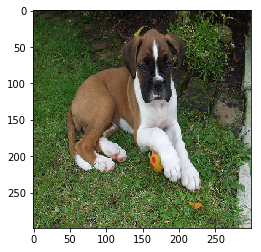

In [384]:
# Preprocess image
processed_image_inception_v3 = preprocess_img(filename)

plt.imshow(deprocess_image(processed_image_inception_v3))

In [179]:
# What is the ground truth label for this image?

truelabel = int(filename[0 : filename.find('_')])
truelabelar = np.zeros((1, 1000))
truelabelar[0,truelabel] = 1.
print('Ground truth Label is %s, class number %i' % (inception_v3.decode_predictions(truelabelar)[0][0][1], truelabel))

# What is the model predicting now?

top_predicted_label = inception_v3.decode_predictions(inception_model.predict(processed_image_inception_v3), top=1)[0][0]
print('Predicted Label is %s, with probability %f' % (top_predicted_label[1], top_predicted_label[2]))

# Has the model got it right?

predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
print('Predicted correctly?', predicted_correctly )

Ground truth Label is boxer, class number 242
Predicted Label is boxer, with probability 0.948531
Predicted correctly? True


Target Label is anemone_fish, class number 393
Example image:


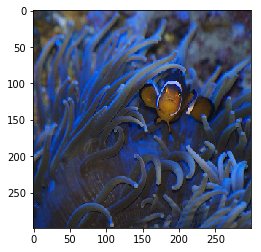

In [183]:
# Generate target class randomly

targets, target_class = generate_target(truelabel)
print('Target Label is %s, class number %i' % (inception_v3.decode_predictions(target_class)[0][0][1], targets))

# Show an example of the target class
filename_ex = [i for i in sorted(os.listdir("imagenetdata/")) if str(targets) == i[0 : i.find('_')]][0]
print('Example image:')
plt.imshow(deprocess_image(preprocess_img(filename_ex)))

*** 
# Examples of attack

### Whitebox base algorithm attack

Running epsilon lambda:  0.005
Attack successful.
Attack successful? True
--- distortion =  0.0048220158
--- attack time:  333.39895009994507 seconds


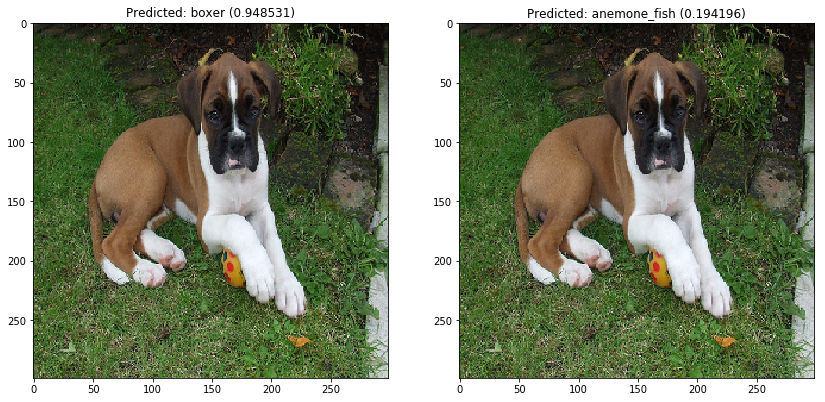

In [193]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

### Whitebox with momentum attack

Attack successful? True
--- distortion =  0.030629039
--- attack time:  4.652271270751953 seconds


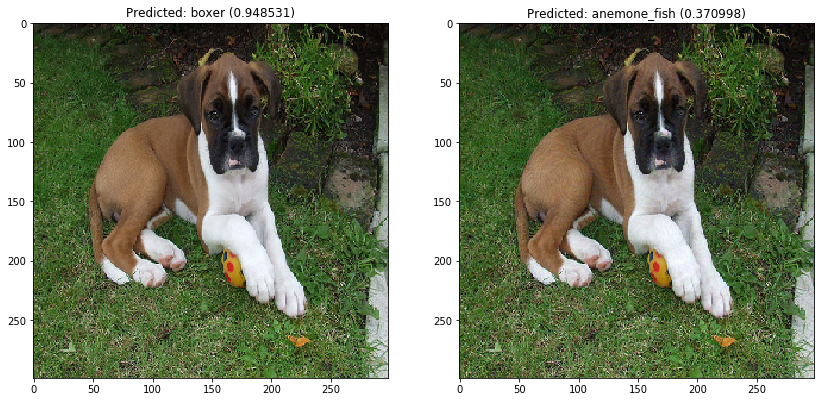

In [198]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

### Blackbox attack

In [ ]:
original_image, new_image, time_took, total_queres, distortion, targetreached = run_blackbox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- total queries: ",total_queres,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

![image](blackboxres.png)

In [ ]:
## Black box with momentum

original_image, new_image, time_took, total_queres, distortion, targetreached = run_blackbox_momentum_attack(processed_image_inception_v3, target_class_fish)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- total queries: ",total_queres,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

***
## Hyperparameter tuning for whitebox base model

Important note: I was time pressured and didn't build in nice parameter tuning functionality in attacks. The following code bits have been ran after modifying attack functions to loop through desired hyperparameter

### Tuning $\gamma$ (from 0.001 to 0.25, increments of 0.001)

In [387]:
results_white_gamma = []
results_white_gamma = run_whitebox_attack(processed_image_inception_v3, target_class, results_white_gamma)
results_white_gamma = pd.DataFrame(results_white_gamma, columns=['gamma_t', 'attack_successful','time','distortion'])

In [263]:
print('Number of successful attacks: ', results_white_gamma[results_white_gamma.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_white_gamma[results_white_gamma.attack_successful == False].shape[0])

Number of successful attacks:  249
Number of unsuccessful attacks:  0


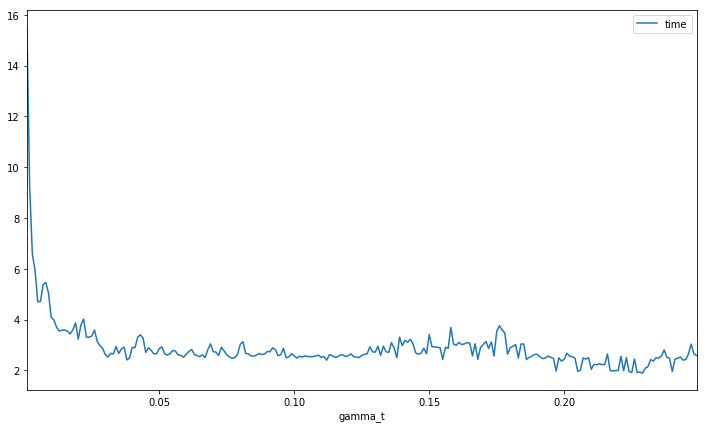

In [264]:
results_white_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='time', kind = 'line',  figsize=(12,7))

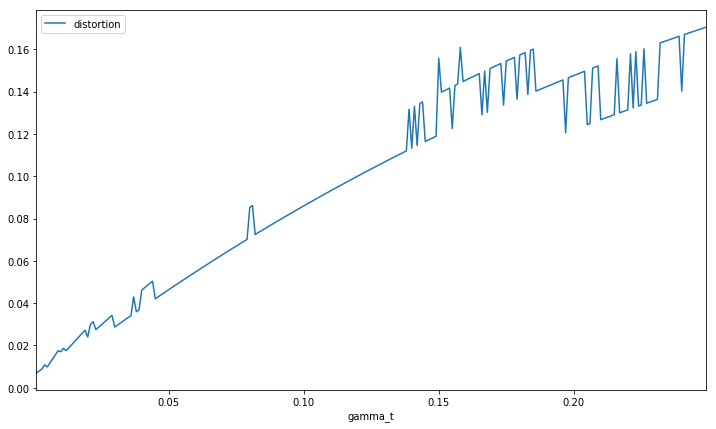

In [265]:
results_white_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='distortion', kind = 'line',  figsize=(12,7))

### Tunning $\epsilon \cdot \lambda$ (from 0.005 to 0.5, increments of 0.005)

In [277]:
results_white_epslam = []
results_white_epslam = run_whitebox_attack(processed_image_inception_v3, target_class, results_white_epslam)
results_white_epslam_df = pd.DataFrame(results_momentum_epsilon, columns=['epsilon_lambda', 'attack_successful', 'time', 'distortion'])

Running epsilon * lambda:  0.005
Running epsilon * lambda:  0.01
Running epsilon * lambda:  0.015
Running epsilon * lambda:  0.02
Running epsilon * lambda:  0.025
Running epsilon * lambda:  0.030000000000000002
Running epsilon * lambda:  0.034999999999999996
Running epsilon * lambda:  0.04
Running epsilon * lambda:  0.045
Running epsilon * lambda:  0.049999999999999996
Running epsilon * lambda:  0.055
Running epsilon * lambda:  0.06
Running epsilon * lambda:  0.065
Running epsilon * lambda:  0.07
Running epsilon * lambda:  0.07500000000000001
Running epsilon * lambda:  0.08
Running epsilon * lambda:  0.085
Running epsilon * lambda:  0.09000000000000001
Running epsilon * lambda:  0.095
Running epsilon * lambda:  0.1
Running epsilon * lambda:  0.10500000000000001
Running epsilon * lambda:  0.11
Running epsilon * lambda:  0.115
Running epsilon * lambda:  0.12000000000000001
Running epsilon * lambda:  0.125
Running epsilon * lambda:  0.13
Running epsilon * lambda:  0.135
Running epsilon * 

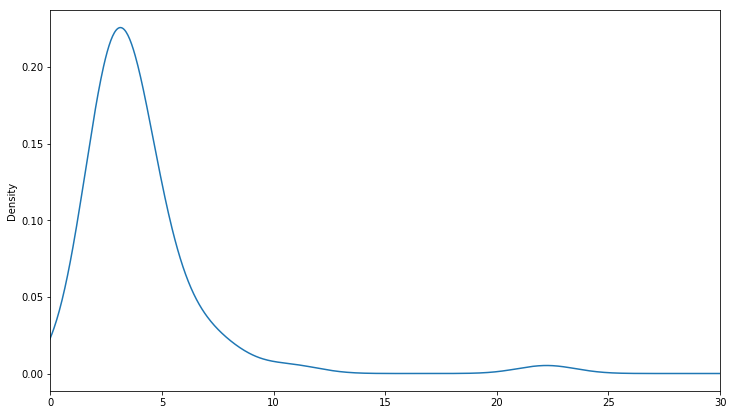

In [391]:
results_white_epslam_df.time.plot(x ='time', kind = 'kde',  figsize=(12,7), xlim=(0,30))

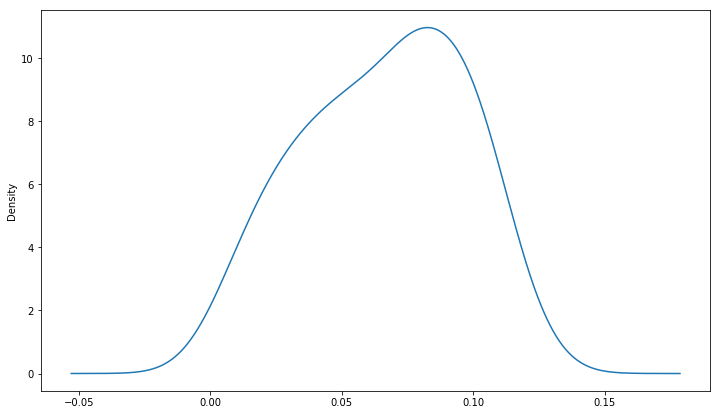

In [394]:
results_white_epslam_df.distortion.plot(x ='time', kind = 'kde',  figsize=(12,7))

In [278]:
print('Number of successful attacks: ', results_white_epslam_df[results_white_epslam_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_white_epslam_df[results_white_epslam_df.attack_successful == False].shape[0])

Number of successful attacks:  59
Number of unsuccessful attacks:  0


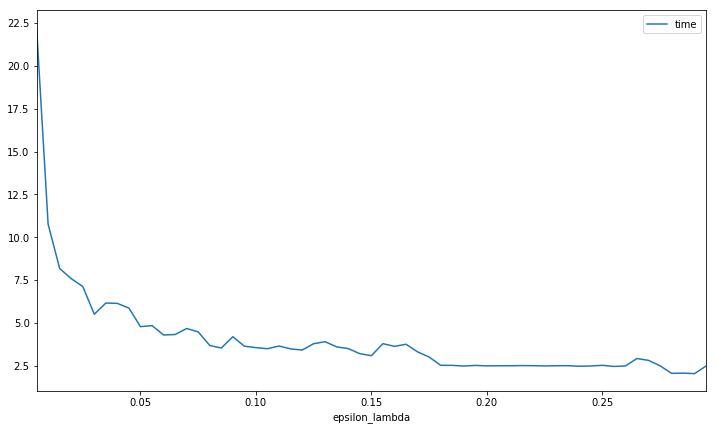

In [280]:
results_white_epslam_df.sort_values(by=['epsilon_lambda']).plot(x ='epsilon_lambda', y='time', kind = 'line',  figsize=(12,7))

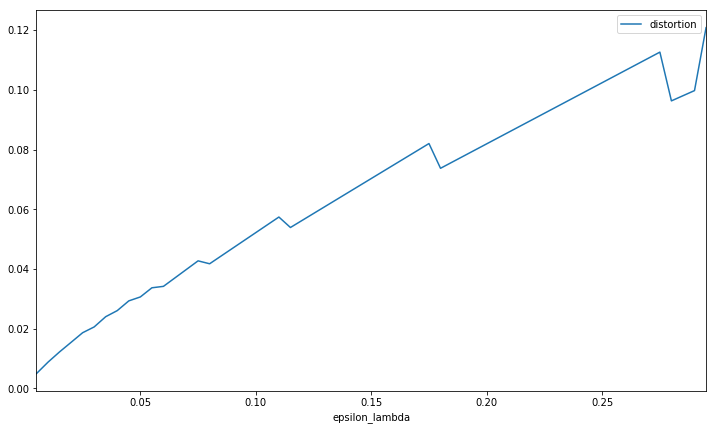

In [281]:
results_white_epslam_df.sort_values(by=['epsilon_lambda']).plot(x ='epsilon_lambda', y='distortion', kind = 'line',  figsize=(12,7))

### Based on results, setting $\gamma = 0.03$, $\epsilon \cdot \lambda = 0.05$

Attack successful.
Attack successful? True
--- distortion =  0.010812879
--- attack time:  4.402148008346558 seconds


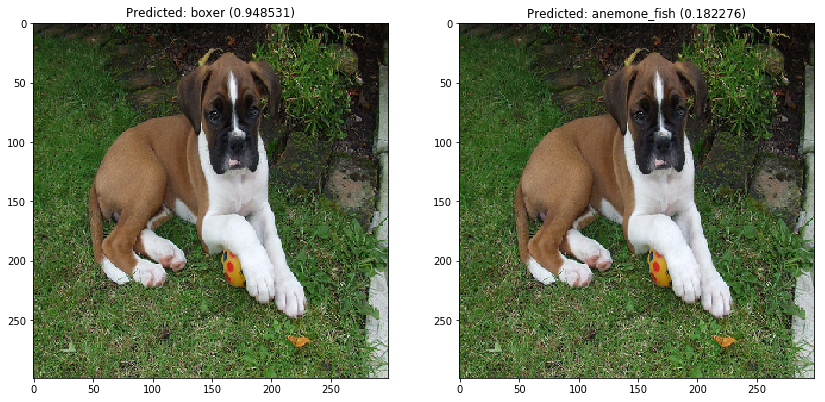

In [284]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

***
## Hyperparameter tuning for whitebox with momentum

Important note: I was time pressured and didn't build in nice parameter tuning functionality in attacks. The following code bits have been ran after modifying attack functions to loop through desired hyperparameter

### Tuning $\gamma$ (from 0.001 to 0.3, increments of 0.001)

In [ ]:
results_momentum_gamma = []
results_momentum_gamma = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_gamma)
results_momentum_gamma = pd.DataFrame(results_momentum_gamma, columns=['gamma_t', 'attack_successful','time','distortion'])

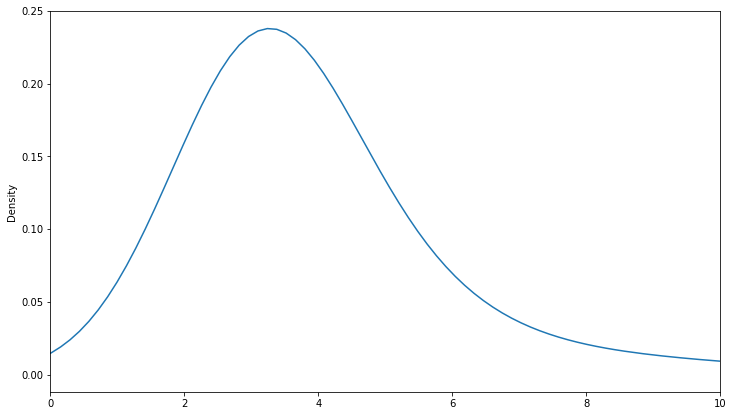

In [397]:
results_momentum_gamma.time.plot(x ='time', kind = 'kde',  figsize=(12,7), xlim=(0,10))

In [269]:
print('Number of successful attacks: ', results_momentum_gamma[results_momentum_gamma.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_gamma[results_momentum_gamma.attack_successful == False].shape[0])

Number of successful attacks:  458
Number of unsuccessful attacks:  0


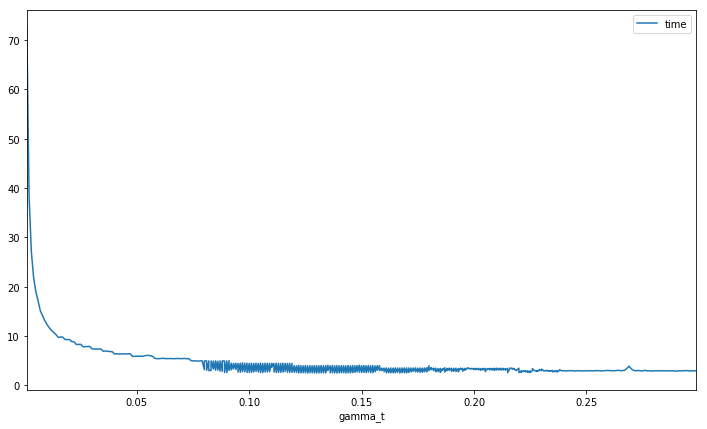

In [249]:
results_momentum_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='time', kind = 'line',  figsize=(12,7))

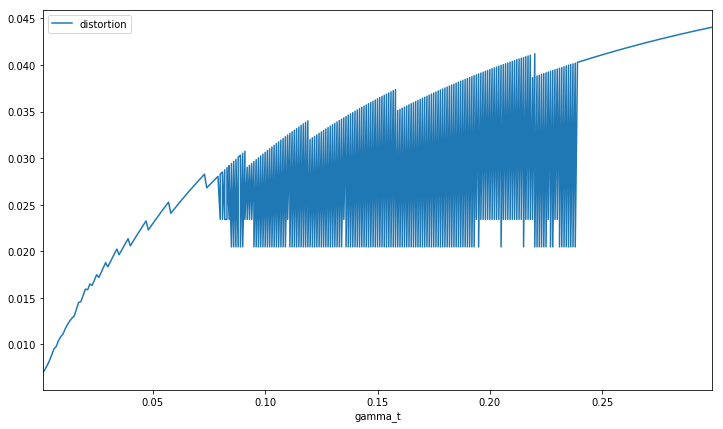

In [250]:
results_momentum_gamma.sort_values(by=['gamma_t']).plot(x ='gamma_t', y='distortion', kind = 'line',  figsize=(12,7))

### Tuning $\beta$ (from 0.8 to 0.99, increments of 0.01)

In [ ]:
results_momentum_beta = []
results_momentum_beta = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_beta)
results_momentum_beta_df = pd.DataFrame(results_momentum_beta, columns=['beta', 'attack_successful', 'time', 'distortion'])

In [399]:
results_momentum_beta_df

beta  attack_successful       time  distortion
0   0.80               True   3.116192    0.023428
1   0.81               True   3.526084    0.026085
2   0.82               True   3.480451    0.026085
3   0.83               True   3.487648    0.026085
4   0.84               True   3.550397    0.026085
5   0.85               True   3.537816    0.026085
6   0.86               True   4.028781    0.028477
7   0.87               True   4.670841    0.028477
8   0.88               True   4.921361    0.028477
9   0.89               True   5.589941    0.030629
10  0.90               True   4.894424    0.030629
11  0.91               True   6.003890    0.032566
12  0.92               True   5.433888    0.032566
13  0.93               True   5.951937    0.034310
14  0.94               True   6.344770    0.035879
15  0.95               True   7.145158    0.037291
16  0.96               True   8.016852    0.039705
17  0.97               True   8.962866    0.041661
18  0.98               True  10.793602    0.044529
19  0.99               True  15.498263    0.048092

In [272]:
print('Number of successful attacks: ', results_momentum_beta_df[results_momentum_beta_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_beta_df[results_momentum_beta_df.attack_successful == False].shape[0])

Number of successful attacks:  20
Number of unsuccessful attacks:  0


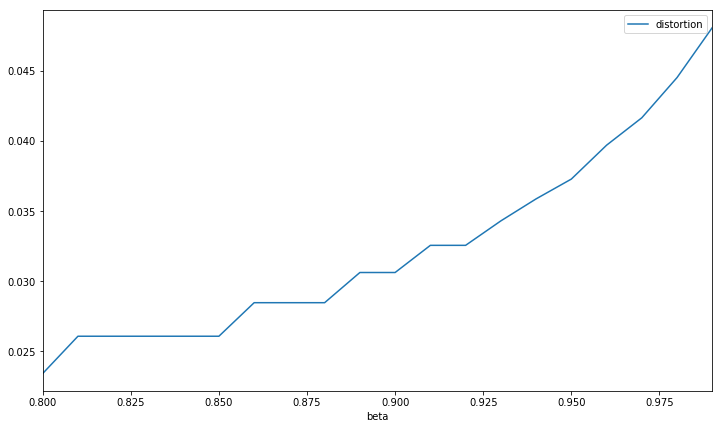

In [233]:
results_momentum_beta_df.plot(x ='beta', y='distortion', kind = 'line',  figsize=(12,7))

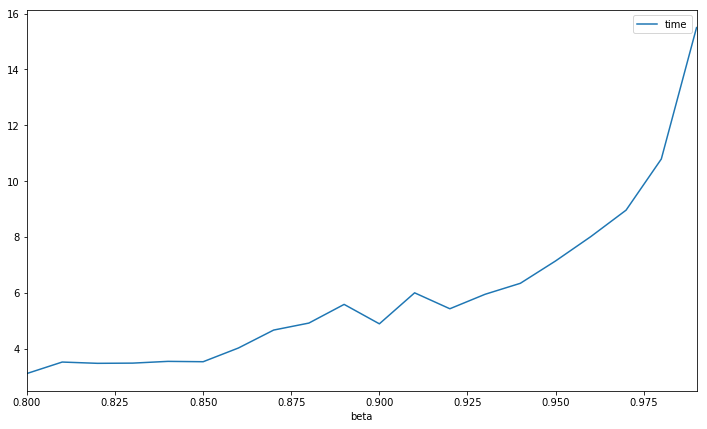

In [234]:
results_momentum_beta_df.plot(x ='beta', y='time', kind = 'line',  figsize=(12,7))

### Tuning $\epsilon$ (from 0.005 to 0.3, increments of 0.005)

In [ ]:
results_momentum_epsilon = []
results_momentum_epsilon = run_whitebox_momentum_attack(processed_image_inception_v3, target_class, results_momentum_epsilon)
results_momentum_epsilon_df = pd.DataFrame(results_momentum_epsilon, columns=['epsilon', 'attack_successful', 'time', 'distortion'])

In [273]:
print('Number of successful attacks: ', results_momentum_epsilon_df[results_momentum_epsilon_df.attack_successful == True].shape[0])
print('Number of unsuccessful attacks: ', results_momentum_epsilon_df[results_momentum_epsilon_df.attack_successful == False].shape[0])

Number of successful attacks:  59
Number of unsuccessful attacks:  0


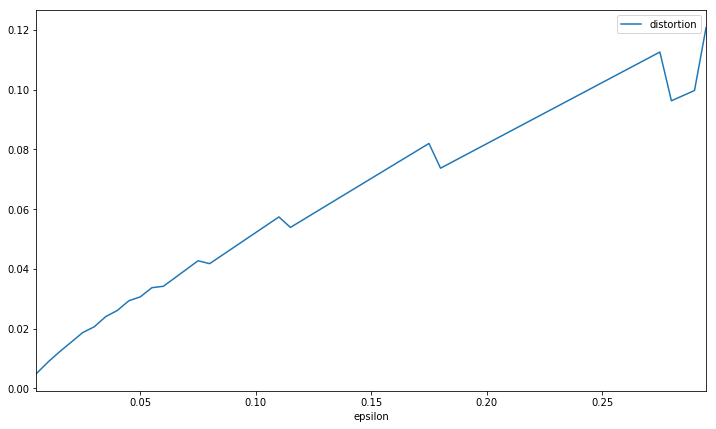

In [247]:
results_momentum_epsilon_df.plot(x ='epsilon', y='distortion', kind = 'line',  figsize=(12,7))

In [248]:
results_momentum_epsilon_df.plot(x ='epsilon', y='time', kind = 'line',  figsize=(12,7))

### Based on results setting $\gamma = 0.05$, $\beta = 0.85$, $\epsilon = 0.1$

running epsilon  0.1
Attack successful? True
--- distortion =  0.030166388
--- attack time:  3.716101884841919 seconds


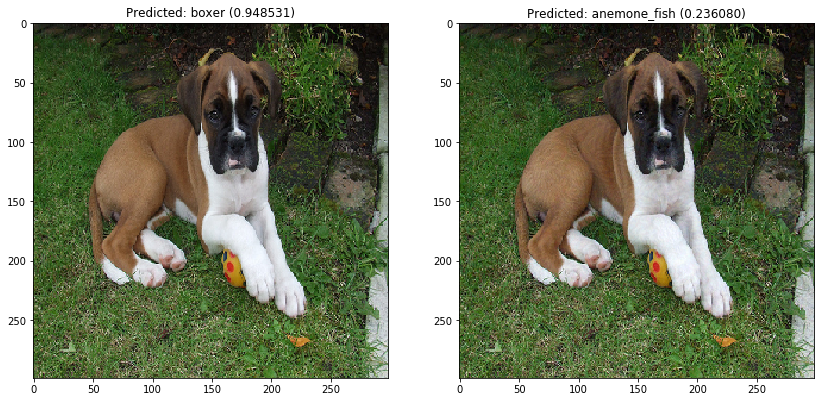

In [254]:
original_image, new_image, time_took, distortion, targetreached = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

print('Attack successful?', targetreached)
print('--- distortion = ', distortion)
print("--- attack time: ",time_took,"seconds")
# Display image now and see how it is classified
plot_sidebyside(original_image, new_image)

*** 
## Running multiple attacks (whitebox models)

The orginal paper presented the averaged results over 500 iterations. It is not clear if the authors ran the attacks on images misclassified by the Inception V3 model. It is also not clear what was the strategy for hyperparameter tuning - the hyperparameters I have chosen are trade off between time taken for the attack and the distortion rate between the original image and the resulting image.

In addition to this, the authors use "time" as the metric. This would not be my choice, as I believe it would be more valid to capture number of iterations done, due to differences in hardware setups and implementation details, which can strongly affect the time a single iteration takes. On the other hand, using iterations would have been a more valid metric, given that this is an optimisation problem, not an engineering problem.

It is important to note that the hyperparameter tuning that was done is very limited, due to time and hardware constraints. A more valid approach would have been to create a grid of values and do grid search, as some values might interact with each other. Finally, all hyperparameters were tuned on one example of the attack, and while that example was kept constant throughout, to enable fair comparison, it would have been better to use multiple attacks.

The original authors claim success rate of 100% for whitebox attacks.
They claim average distortion of 0.003 and average time of 13.7 seconds. It would have been useful if the authors presented distribution curves for times and distortion, to understand variability.


The runs below achieved (for base algorithm, as it's the fairest comparison) run time with mean 6.27 seconds and median 5.40. This is lower most likely due to the way hyperparameters were tuned - I suspect that the original authors were optimising for distortion only. The experiments resulted in distortion with mean 0.0128, and median 0.0119. This is higher, I suspect for the same reasons.

Experiments did not yield a claimed 100% success rate, but both base whitebox model and model with momentum have failed 12 attacks. This represents the success rate of 97.6%. It's important to note that I used a lower maximum iterations of 1000, compared to 10000 of the original authors (time and computing constraints). However, some runs were attempted over 10000 iterations and the model still failed to attack successfully. Honestly, I am suspicious of the 100% success claimed by the authors.

The Inception V3 model accurately predicted (top-1 accuracy) 74.55% of the images. I did not perform the attacks on images that were not correctly classified by the Imagenet model.

Full code and result overview is below.

In [310]:
# Lists in which results are kept
result_list = []
image_list = []

In [ ]:
for experiment in range(0,500):
    print('***********Running experiment: ', experiment,'**************')
    
    # Option 1 : Randomly choose an image
    filename = random.choice(os.listdir("imagenetdata/"))
    
    # Preprocess image
    processed_image_inception_v3 = preprocess_img(filename)

    # What is the ground truth label for this image?
    truelabel = int(filename[0 : filename.find('_')])
    truelabelar = np.zeros((1, 1000))
    truelabelar[0,truelabel] = 1.
    
    # Has the model got it right?
    predicted_correctly, predicted_label  = run_classification(processed_image_inception_v3, truelabel)
    
    if predicted_correctly:
        # Generate target randomly
        targets, target_class = generate_target(truelabel)
        filename_ex = [i for i in sorted(os.listdir("imagenetdata/")) if str(targets) == i[0 : i.find('_')]][0]
        example_img = preprocess_img(filename_ex)

        # White box attack
        original_image, new_image, time_took, distortion, targetreached = run_whitebox_attack(processed_image_inception_v3, target_class)

        # Momentum attack
        original_image_m, new_image_m, time_took_m, distortion_m, targetreached_m = run_whitebox_momentum_attack(processed_image_inception_v3, target_class)

        # Add results to the lists
        result_list.append([experiment, filename, truelabel, targets, time_took, distortion, 
                            targetreached, time_took_m, distortion_m, targetreached_m])
        image_list.append([experiment, example_img, processed_image_inception_v3, new_image, new_image_m])
        

In [ ]:
# Convert lists into Pandas dataframe
results_df = pd.DataFrame(result_list, columns=['experiment_id', 'target_image', 'label','target','white_box_time',
                         'white_box_distortion', 'whitebox_successful','momentum_time',
                         'momentum_distortion', 'momentum_successful'])

images_df = pd.DataFrame(image_list, columns=['experiment_id', 'example_image', 'original_image', 'whitebox_image', 'momentum_image'])

In [432]:

total_exp = results_df.iloc[-1].experiment_id
print('Number of experiments ran:', total_exp)
print('Model failed to correctly classify',total_exp-results_df.shape[0],'images')
print('Imagenet accuracy over experiments:',100*(total_exp-(total_exp-results_df.shape[0]))/total_exp,'%\n')

print('Total images attacked:', results_df.shape[0],'\n')
print('Base failed an attack in',results_df[results_df.whitebox_successful == False].shape[0],'run(s)')
print('Momentum failed an attack in',results_df[results_df.momentum_successful == False].shape[0],'run(s)\n')

print('Base success rate:',100*results_df[results_df.whitebox_successful == True].shape[0]/results_df.shape[0],'%')
print('Momentum success rate:',100*results_df[results_df.momentum_successful == True].shape[0]/results_df.shape[0],'%\n')

print('Base was faster in',results_df[results_df.white_box_time < results_df.momentum_time].shape[0],'runs')
print('Momentum was faster in',results_df[results_df.white_box_time > results_df.momentum_time].shape[0],'runs\n')

print('Base distortion was lower in',results_df[results_df.white_box_distortion < results_df.momentum_distortion].shape[0],'runs')
print('Momentum distrtion was lower in',results_df[results_df.white_box_distortion > results_df.momentum_distortion].shape[0],'runs')

Number of experiments ran: 672
Model failed to correctly classify 171 images
Imagenet accuracy over experiments: 74.55357142857143 %

Total images attacked: 501 

Base failed an attack in 12 run(s)
Momentum failed an attack in 12 run(s)

Base success rate: 97.60479041916167 %
Momentum success rate: 97.60479041916167 %

Base was faster in 172 runs
Momentum was faster in 329 runs

Base distortion was lower in 489 runs
Momentum distrtion was lower in 0 runs


In [464]:
results_df[['white_box_time', 'white_box_distortion', 'momentum_time', 'momentum_distortion']][results_df.whitebox_successful == True].describe()

white_box_time  white_box_distortion  momentum_time  \
count      489.000000            489.000000     489.000000   
mean         6.270866              0.012583       5.060869   
std          3.926864              0.005851       2.095291   
min          0.773278              0.001500       0.898243   
25%          3.851477              0.008351       3.653492   
50%          5.402110              0.011989       4.819866   
75%          7.707719              0.015308       6.103386   
max         36.919414              0.041190      13.557246   

       momentum_distortion  
count           489.000000  
mean              0.033219  
std               0.010719  
min               0.005000  
25%               0.026491  
50%               0.033658  
75%               0.040126  
max               0.064151

In [469]:
np.median(results_df[results_df.whitebox_successful == True].white_box_time)

5.402109861373901

In [470]:
np.median(results_df[results_df.whitebox_successful == True].white_box_distortion)

0.011988520622253418

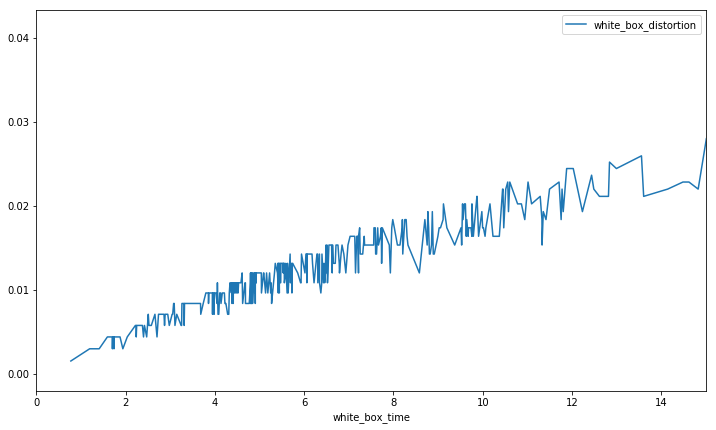

In [452]:
results_df.sort_values(by=['white_box_time']).plot(x ='white_box_time', y='white_box_distortion', kind = 'line',  figsize=(12,7), xlim=(0,15))

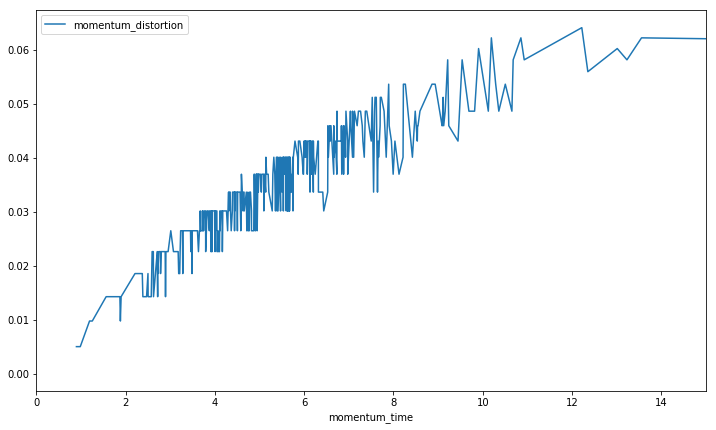

In [453]:
results_df.sort_values(by=['momentum_time']).plot(x ='momentum_time', y='momentum_distortion', kind = 'line',  figsize=(12,7), xlim=(0,15))

## Visualising some experimental results

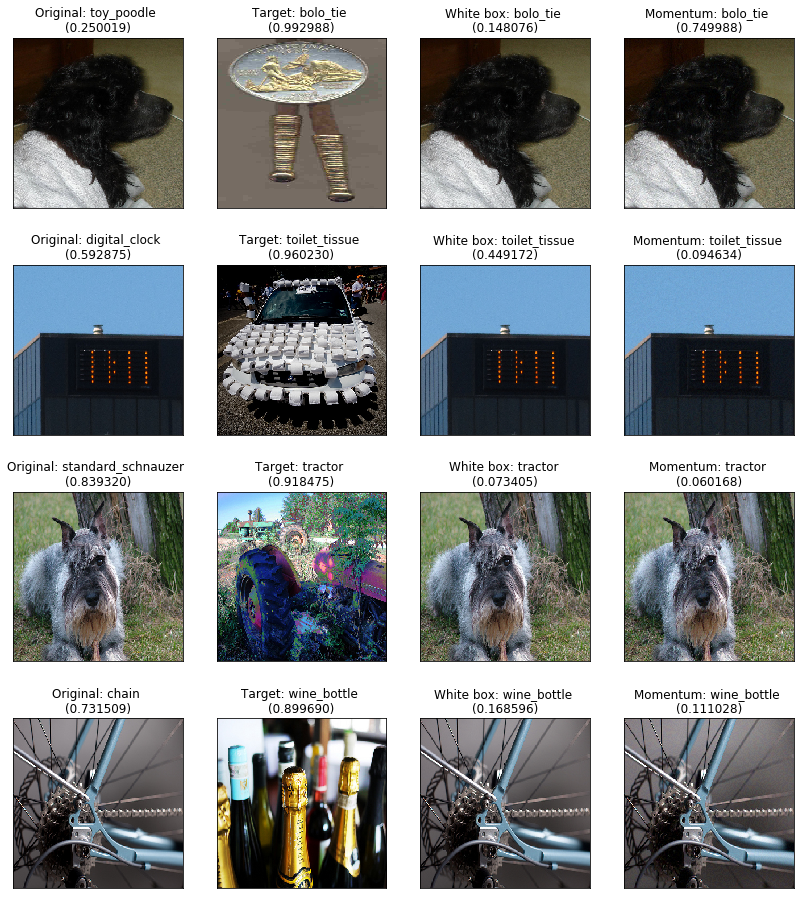

In [405]:
plot_grid(7, images_df)

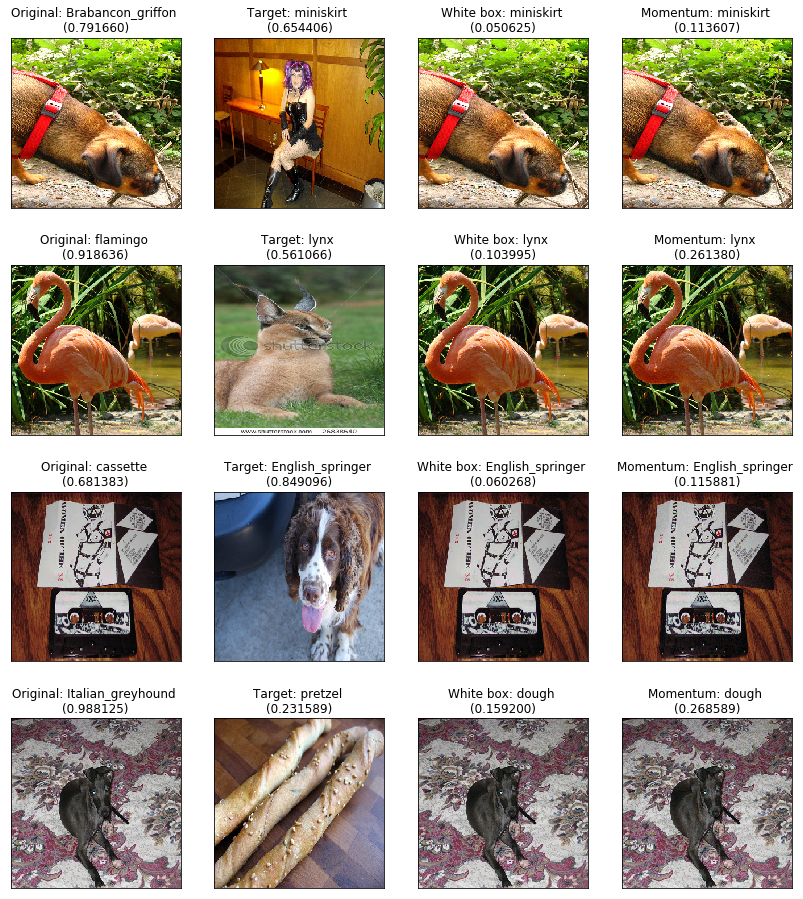

In [406]:
plot_grid(11, images_df)

In [407]:
plot_grid(15, images_df)

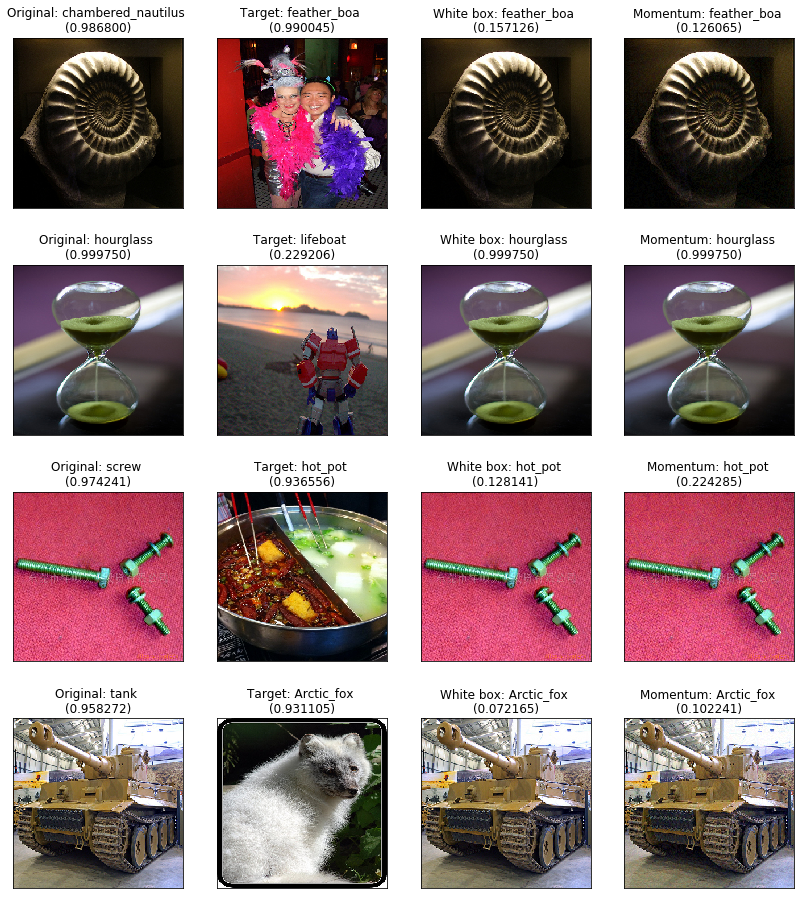

In [408]:
plot_grid(19, images_df)